In [642]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping

def create_features(dtf) :
    """
    Create time series features from the time index.
    :param dtf: dataframe
    :return:dataframe
    """
    dtf = dtf.copy()
    dtf['dayofweek'] = dtf.index.dayofweek
    dtf['month'] = dtf.index.month
    # dtf['year'] = dtf.index.year
    dtf['dayofyear'] = dtf.index.dayofyear
    dtf['dayofmonth'] = dtf.index.day
    dtf['weekofyear'] = dtf.index.isocalendar().week
    dtf['quarter'] = dtf.index.quarter
    return dtf

def add_lags_for_calls(dtf):
    target_map = dtf['calls'].to_dict()
    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf


def add_lags_sick(dtf):
    target_map = dtf['n_sick'].to_dict()

    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf

def add_lags(dtf):
    target_map = dtf['sby_need'].to_dict()

    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf

In [643]:
import tensorflow as tf

def huber_loss(y_true, y_pred, delta=1.0):
    y_true = tf.cast(y_true, dtype=y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    error = y_true - y_pred
    quadratic_term = 0.5 * tf.square(error)
    linear_term = delta * (tf.abs(error) - 0.5 * delta)
    condition = tf.abs(error) < delta
    return tf.where(condition, quadratic_term, linear_term)




In [644]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

df = pd.read_csv('sickness_table.csv')
color_pal = sns.color_palette()
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df = df.drop(['Unnamed: 0', 'n_sby', 'dafted'], axis=1)
df_calls = pd.DataFrame({'calls': df['calls'].values}, index=df.index)
df_sick = pd.DataFrame({'n_sick': df['n_sick'].values}, index=df.index)
df_sick = create_features(df_sick)
df_calls = create_features(df_calls)

df_sick = add_lags_sick(df_sick)
df_calls = add_lags_for_calls(df_calls)
df_sick.fillna(0, inplace=True)
df_calls.fillna(0, inplace=True)

n_sick_features = ['dayofweek', 'month', 'dayofyear', 'quarter',  'lag1', 'lag2']
n_sick_target = 'n_sick'
n_sick_data = df_sick[n_sick_features + [n_sick_target]]

calls_features = ['dayofweek', 'month', 'dayofyear', 'quarter',  'lag1', 'lag2']
calls_target = 'calls'
calls_data = df_calls[calls_features + [calls_target]]

X_n_sick = n_sick_data[n_sick_features].values
y_n_sick = n_sick_data[n_sick_target].values

X_calls = calls_data[calls_features].values
y_calls = calls_data[calls_target].values

X_n_sick_temp, X_n_sick_test, y_n_sick_temp, y_n_sick_test = train_test_split(X_n_sick, y_n_sick, test_size=80, shuffle=False)
X_n_sick_train, X_n_sick_val, y_n_sick_train, y_n_sick_val = train_test_split(X_n_sick_temp, y_n_sick_temp, test_size=0.5, shuffle=False)

X_calls_temp, X_calls_test, y_calls_temp, y_calls_test = train_test_split(X_calls, y_calls, test_size=80, shuffle=False)
X_calls_train, X_calls_val, y_calls_train, y_calls_val = train_test_split(X_calls_temp, y_calls_temp, test_size=0.5, shuffle=False)

scaler_n_sick = MinMaxScaler()
scaler_calls = MinMaxScaler()

X_n_sick_train = scaler_n_sick.fit_transform(X_n_sick_train)
X_n_sick_val = scaler_n_sick.transform(X_n_sick_val)
X_n_sick_test = scaler_n_sick.transform(X_n_sick_test)

X_calls_train = scaler_calls.fit_transform(X_calls_train)
X_calls_val = scaler_calls.transform(X_calls_val)
X_calls_test = scaler_calls.transform(X_calls_test)

model_n_sick = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_n_sick_train.shape[1],)),
    # layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_n_sick.compile(optimizer='adam', loss=huber_loss)


model_calls = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_calls_train.shape[1],)),
    # layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_calls.compile(optimizer='adam', loss=huber_loss)

early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)

history_n_sick = model_n_sick.fit(X_n_sick_train, y_n_sick_train, epochs=200, batch_size=64, validation_data=(X_n_sick_val, y_n_sick_val), verbose=2, callbacks=[early_stopping])

history_calls = model_calls.fit(X_calls_train, y_calls_train, epochs=200, batch_size=64, validation_data=(X_calls_val, y_calls_val), verbose=2, callbacks=[early_stopping])

predicted_n_sick = model_n_sick.predict(X_n_sick_test)
predicted_calls = model_calls.predict(X_calls_test)


Epoch 1/200
9/9 - 5s - loss: 60.0022 - val_loss: 69.3877 - 5s/epoch - 593ms/step
Epoch 2/200
9/9 - 0s - loss: 59.5878 - val_loss: 61.8807 - 184ms/epoch - 20ms/step
Epoch 3/200
9/9 - 0s - loss: 59.1200 - val_loss: 54.4667 - 116ms/epoch - 13ms/step
Epoch 4/200
9/9 - 0s - loss: 58.4972 - val_loss: 46.3391 - 150ms/epoch - 17ms/step
Epoch 5/200
9/9 - 0s - loss: 57.5929 - val_loss: 37.1180 - 205ms/epoch - 23ms/step
Epoch 6/200
9/9 - 0s - loss: 56.2678 - val_loss: 33.1410 - 137ms/epoch - 15ms/step
Epoch 7/200
9/9 - 0s - loss: 54.3707 - val_loss: 40.5523 - 216ms/epoch - 24ms/step
Epoch 8/200
9/9 - 0s - loss: 51.7589 - val_loss: 54.5322 - 247ms/epoch - 27ms/step
Epoch 9/200
9/9 - 0s - loss: 48.2564 - val_loss: 71.3313 - 213ms/epoch - 24ms/step
Epoch 10/200
9/9 - 0s - loss: 43.6345 - val_loss: 90.0687 - 125ms/epoch - 14ms/step
Epoch 11/200
9/9 - 0s - loss: 37.8295 - val_loss: 110.8626 - 63ms/epoch - 7ms/step
Epoch 12/200
9/9 - 0s - loss: 30.6231 - val_loss: 133.6915 - 79ms/epoch - 9ms/step
Epoch

In [645]:
# Convert predictions to dataframes with dates as index
predicted_n_sick_df = pd.DataFrame(predicted_n_sick, columns=['predicted_n_sick'], index=n_sick_data.index[-len(y_n_sick_test):])
predicted_calls_df = pd.DataFrame(predicted_calls, columns=['predicted_calls'], index=calls_data.index[-len(y_calls_test):])
predicted_calls_df

,predicted_calls
date,
2019-03-09,7956.118652
2019-03-10,6919.379395
2019-03-11,6507.550781
2019-03-12,7576.224121
2019-03-13,8100.978027
...,...
2019-05-23,7115.452637
2019-05-24,7444.291992
2019-05-25,7684.746094


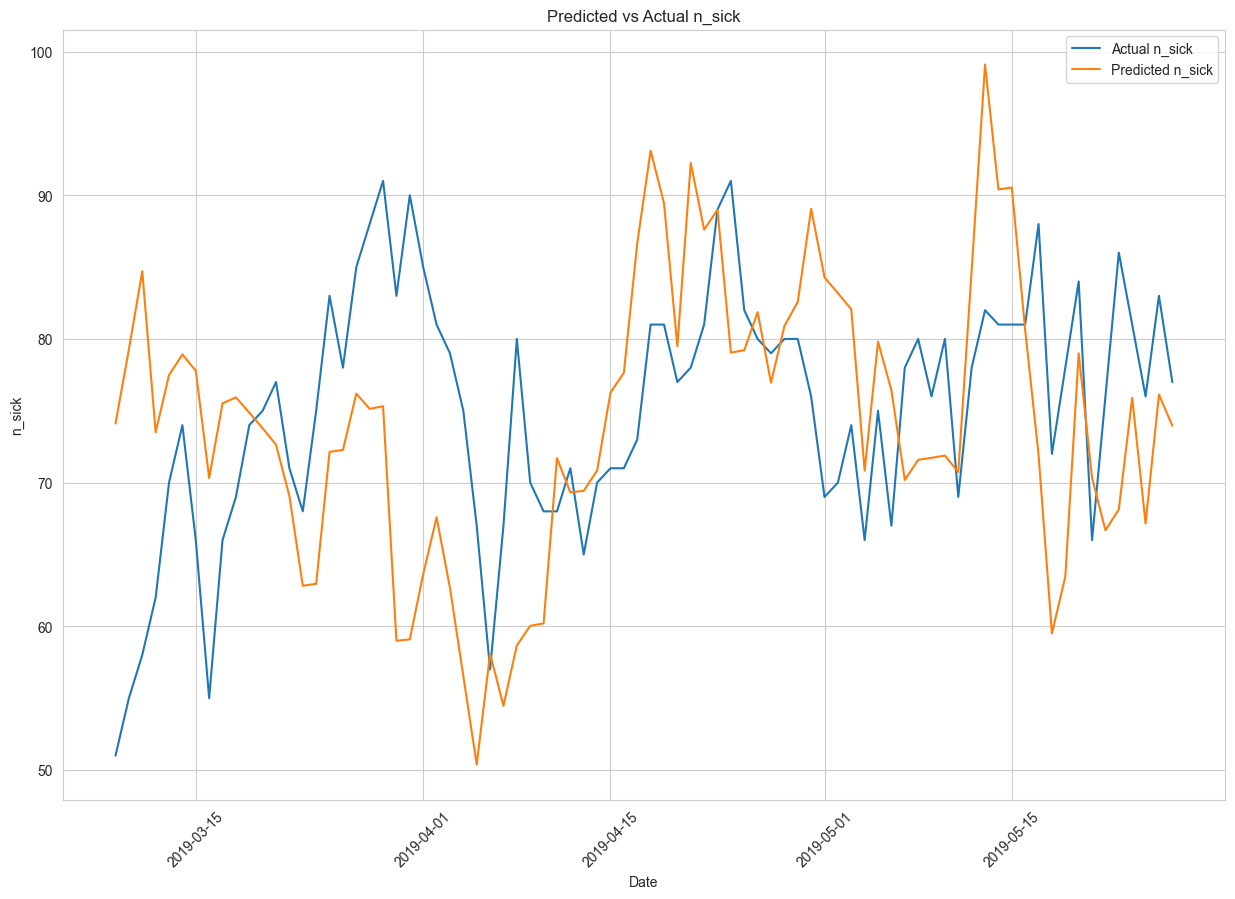

MAE for n_sick prediction: 9.535833930969238
11.675980554103822
MAE for calls prediction: 1309.4366577148437
1584.5738001317372


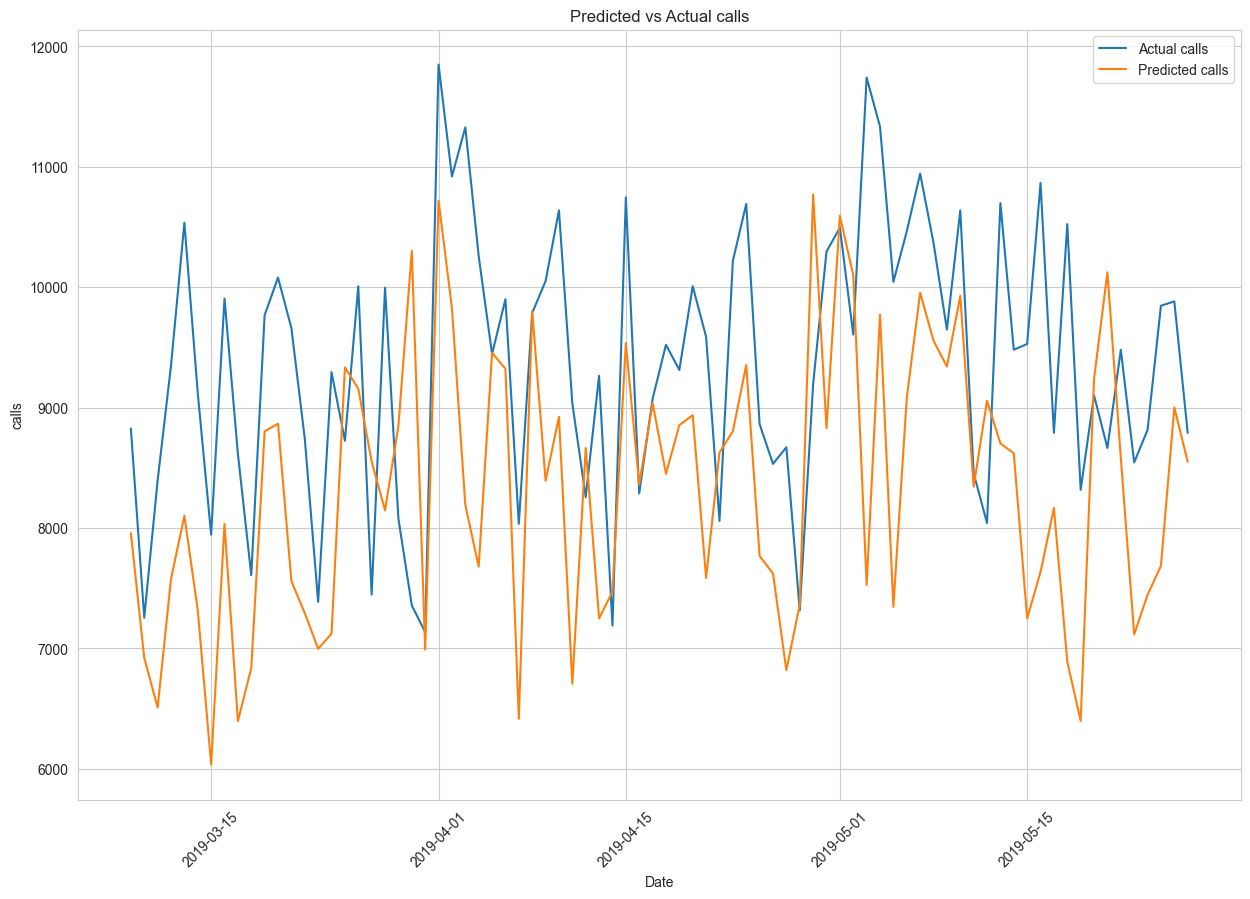

MAE for calls: 1309.4366577148437


In [646]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

plt.figure(figsize=(15, 10))
plt.plot(predicted_n_sick_df.index, y_n_sick_test, label='Actual n_sick', color=color_pal[0])
plt.plot(predicted_n_sick_df.index, predicted_n_sick_df['predicted_n_sick'], label='Predicted n_sick', color=color_pal[1])
plt.xlabel('Date')
plt.ylabel('n_sick')
plt.title('Predicted vs Actual n_sick')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Predicted vs Actual n_sick-neural.png')
plt.show()

mae_n_sick = np.mean(np.abs(predicted_n_sick_df['predicted_n_sick'] - y_n_sick_test))
print('MAE for n_sick prediction:', mae_n_sick)
score = np.sqrt(mean_squared_error(predicted_n_sick_df['predicted_n_sick'],y_n_sick_test))
print(score)

mae_calls = np.mean(np.abs(predicted_calls_df['predicted_calls'] - y_calls_test))
print('MAE for calls prediction:', mae_calls)
score = np.sqrt(mean_squared_error(predicted_calls_df['predicted_calls'],y_calls_test))
print(score)

plt.figure(figsize=(15, 10))
plt.plot(predicted_calls_df.index, y_calls_test, label='Actual calls', color=color_pal[0])
plt.plot(predicted_calls_df.index, predicted_calls_df['predicted_calls'], label='Predicted calls', color=color_pal[1])
plt.xlabel('Date')
plt.ylabel('calls')
plt.title('Predicted vs Actual calls')
plt.legend()
plt.xticks(rotation=45)
plt.savefig('Predicted vs Actual calls - neural.png')
plt.show()
mae_calls = np.mean(np.abs(predicted_calls_df['predicted_calls'] - y_calls_test))
print('MAE for calls:', mae_calls)


In [647]:
from tensorflow.python.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

data = pd.read_csv('sickness_table.csv', parse_dates=['date'], index_col='date')
color_pal = sns.color_palette()
data = create_features(data)
data = add_lags(data)
data.fillna(0, inplace=True)
features = ['n_sick', 'calls', 'n_duty', 'dayofweek', 'month', 'dayofyear', 'quarter',  'lag1', 'lag2']

target = 'sby_need'
data = data[features + [target]]

X = data[features]
y = data[target]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=80, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False)

scaler_calls = MinMaxScaler()
scalar_sick = MinMaxScaler()
scalar_duty = MinMaxScaler()
scalar = MinMaxScaler()
columns_to_scale = ['dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']

X_train['calls'] = scaler_calls.fit_transform(X_train['calls'].values.reshape(-1, 1))
X_val['calls'] = scaler_calls.transform(X_val['calls'].values.reshape(-1, 1))
X_test['calls'] = scaler_calls.transform(X_test['calls'].values.reshape(-1, 1))

X_train['n_sick'] = scalar_sick.fit_transform(X_train['n_sick'].values.reshape(-1, 1))
X_val['n_sick'] = scalar_sick.transform(X_val['n_sick'].values.reshape(-1, 1))
X_test['n_sick'] = scalar_sick.transform(X_test['n_sick'].values.reshape(-1, 1))

X_train['n_duty'] = scalar_duty.fit_transform(X_train['n_duty'].values.reshape(-1, 1))
X_val['n_duty'] = scalar_duty.transform(X_val['n_duty'].values.reshape(-1, 1))
X_test['n_duty'] = scalar_duty.transform(X_test['n_duty'].values.reshape(-1, 1))

X_train[columns_to_scale] = scalar.fit_transform(X_train[columns_to_scale])
X_val[columns_to_scale] = scalar.transform(X_val[columns_to_scale])
X_test[columns_to_scale] = scalar.transform(X_test[columns_to_scale])
X_train[columns_to_scale]

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')
early_stopping = EarlyStopping(monitor='val_loss',   patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

input_layer_weights = np.abs(model.layers[0].get_weights()[0]).sum(axis=1)

importance_df = pd.DataFrame({'Feature': features, 'Importance': input_layer_weights})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,4), facecolor='white')
sns.barplot(x='Importance', y='Feature', data=importance_df, color=color_pal[0], width=0.1)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig('Feature Importance.png')
plt.show()


,dayofweek,month,dayofyear,quarter,lag1,lag2
date,,,,,,
2016-04-01,0.666667,0.272727,0.249315,0.333333,0.000000,0.0
2016-04-02,0.833333,0.272727,0.252055,0.333333,0.000000,0.0
2016-04-03,1.000000,0.272727,0.254795,0.333333,0.000000,0.0
2016-04-04,0.000000,0.272727,0.257534,0.333333,0.000000,0.0
2016-04-05,0.166667,0.272727,0.260274,0.333333,0.000000,0.0
...,...,...,...,...,...,...
2018-04-16,0.000000,0.272727,0.287671,0.333333,0.149675,0.0
2018-04-17,0.166667,0.272727,0.290411,0.333333,0.000000,1.0
2018-04-18,0.333333,0.272727,0.293151,0.333333,0.000000,0.0


In [693]:
columns_to_scale = ['dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']

# Combining predicted n_sick, calls, and n_duty values to create X_test_new for sby_need prediction
X_test_new = pd.DataFrame({'n_sick': predicted_n_sick_df['predicted_n_sick'], 'calls': predicted_calls_df['predicted_calls'], 'n_duty': df.loc[predicted_calls_df.index, 'n_duty']})

X_test_new["dayofweek"] = X_test_new.index.dayofweek
X_test_new["month"] = X_test_new.index.month
X_test_new["dayofyear"] = X_test_new.index.dayofyear
X_test_new["quarter"] = X_test_new.index.quarter
X_test_new["lag1"] = data.loc[X_test_new.index, 'lag1']
X_test_new["lag2"] = data.loc[X_test_new.index, 'lag2']


X_test_new['calls'] = scaler_calls.transform(X_test_new['calls'].values.reshape(-1, 1))
X_test_new['n_sick'] = scalar_sick.transform(X_test_new['n_sick'].values.reshape(-1, 1))
X_test_new['n_duty'] = scalar_duty.transform(X_test_new['n_duty'].values.reshape(-1, 1))
X_test_new[columns_to_scale] = scalar.transform(X_test_new[columns_to_scale])
X_test_new['calls'] = X_test_new['calls'] + (120/800)



In [672]:
X_test

,n_sick,calls,n_duty,dayofweek,month,dayofyear,quarter,lag1,lag2
date,,,,,,,,,
2019-03-09,0.180723,0.703375,1.0,0.833333,0.181818,0.183562,0.000000,0.000000,0.0
2019-03-10,0.228916,0.470693,1.0,1.000000,0.181818,0.186301,0.000000,0.000000,0.0
2019-03-11,0.265060,0.639432,1.0,0.000000,0.181818,0.189041,0.000000,0.000000,0.0
2019-03-12,0.313253,0.780639,1.0,0.166667,0.181818,0.191781,0.000000,0.138829,0.0
2019-03-13,0.409639,0.956483,1.0,0.333333,0.181818,0.194521,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
2019-05-23,0.602410,0.661634,1.0,0.500000,0.363636,0.389041,0.333333,0.000000,0.0
2019-05-24,0.542169,0.701599,1.0,0.666667,0.363636,0.391781,0.333333,0.000000,0.0
2019-05-25,0.481928,0.854352,1.0,0.833333,0.363636,0.394521,0.333333,0.000000,0.0


In [694]:


predicted_y = model.predict(X_test)

results_df = pd.DataFrame({
    'Original_y': y_test,
    'Predicted_y': model.predict(X_test).flatten()
}, index=predicted_calls_df.index)

predicted_y_new = model.predict(X_test_new)

results_df_new = pd.DataFrame({
    'Original_y': y_test,
    'Predicted_y': model.predict(X_test_new).flatten()
}, index=predicted_calls_df.index)


3/3 [==============================] - 0s 3ms/step


In [680]:
def activation_rate_metric(df):
    mape = (np.abs(df['Predicted_y'] - df['Original_y']).mean()*100)/df['Predicted_y'].mean()
    return mape

def insufficient_standbys_metric(df):
    insufficient_standbys = (df['Predicted_y'] < df['Original_y']).mean() * 100
    return 100-insufficient_standbys

def efficiency_metric(df):
    MAPE = activation_rate_metric(df)
    insufficient_standbys = insufficient_standbys_metric(df)
    #  weights
    activation_weight =1.0
    insufficient_weight = 1.5
    # higher efficiency scores correspond to lower MAPE and insufficiency rates
    inverse_activation_rate = 100 - MAPE
    inverse_insufficient_standbys = 100 - insufficient_standbys
    efficiency_score = (activation_weight * inverse_activation_rate) + (insufficient_weight * inverse_insufficient_standbys)

    return efficiency_score

In [653]:
comparison_df = pd.DataFrame({
    'Original_y': results_df['Original_y'],
    'Predicted_y': 90
})
comparison_df.index = results_df.index
comparison_df

,Original_y,Predicted_y
date,,
2019-03-09,0.0,90
2019-03-10,0.0,90
2019-03-11,0.0,90
2019-03-12,32.0,90
2019-03-13,278.0,90
...,...,...
2019-05-23,0.0,90
2019-05-24,0.0,90
2019-05-25,146.0,90


In [654]:
brand_new_df = pd.DataFrame({
    'Original_y': results_df['Original_y'],
    'Predicted_y': results_df['Predicted_y'],
    'n_sby' : comparison_df['Predicted_y'],
    'Activation Rate':activation_rate_metric(results_df),
    'Old Activation Rate' : activation_rate_metric(comparison_df)

})
brand_new_df

,Original_y,Predicted_y,n_sby,Activation Rate,Old Activation Rate
date,,,,,
2019-03-09,0.0,-0.057989,90,-0.000000,0.000000
2019-03-10,0.0,-0.052577,90,-0.000000,0.000000
2019-03-11,0.0,-0.071536,90,-0.000000,0.000000
2019-03-12,32.0,35.435986,90,90.303680,35.555556
2019-03-13,278.0,275.709137,90,100.830902,308.888889
...,...,...,...,...,...
2019-05-23,0.0,-0.069788,90,-0.000000,0.000000
2019-05-24,0.0,-0.066294,90,-0.000000,0.000000
2019-05-25,146.0,144.623291,90,100.951927,162.222222


In [682]:
ef = efficiency_metric(results_df_new)
ef_test = efficiency_metric(results_df)
ef_or = efficiency_metric(comparison_df)
print(ef)
print(ef_test)
print(ef_or)

104.98205975951686
185.44491816759862
39.80555555555556


In [656]:
artest = activation_rate_metric(results_df)
intest = insufficient_standbys_metric(results_df)
ar_new = activation_rate_metric(results_df_new)
in_new = insufficient_standbys_metric(results_df_new)
ar_orig = activation_rate_metric(comparison_df)
in_orig = insufficient_standbys_metric(comparison_df)
print('Activation rate for test', artest)
print('Insuff sby rate for test',intest)
print('Activation rate for pred',ar_new)
print('Insuff sby rate for pred',in_new)
print('Activation rate for Original',ar_orig)
print('Insuff sby rate for Original',in_orig)

Activation rate for test date
2019-03-09     -0.000000
2019-03-10     -0.000000
2019-03-11     -0.000000
2019-03-12     90.303680
2019-03-13    100.830902
                 ...    
2019-05-23     -0.000000
2019-05-24     -0.000000
2019-05-25    100.951927
2019-05-26    101.465729
2019-05-27     -0.000000
Length: 80, dtype: float32
Insuff sby rate for test 2.5
Activation rate for pred date
2019-03-09        -0.000000
2019-03-10        -0.000000
2019-03-11        -0.000000
2019-03-12    -45135.085938
2019-03-13   -413884.750000
                  ...      
2019-05-23        -0.000000
2019-05-24        -0.000000
2019-05-25   -211072.031250
2019-05-26   -285425.187500
2019-05-27        -0.000000
Length: 80, dtype: float32
Insuff sby rate for pred 51.24999999999999
Activation rate for Original date
2019-03-09      0.000000
2019-03-10      0.000000
2019-03-11      0.000000
2019-03-12     35.555556
2019-03-13    308.888889
                 ...    
2019-05-23      0.000000
2019-05-24      0.0000

In [657]:
def modify_predicted_y(row):
    threshold = 2
    if row['Predicted_y'] < 50:
        return 50
    # if X_test_new.loc[row.name, 'calls'] > threshold:
    #     return row['Predicted_y'] + 200
    return row['Predicted_y']


In [658]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
mae = mean_absolute_error(results_df['Original_y'], results_df['Predicted_y'])
rmse = np.sqrt(mean_squared_error(results_df['Original_y'], results_df['Predicted_y']))

print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

print(r2_score(results_df['Original_y'], results_df['Predicted_y']))


# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
mae = mean_absolute_error(results_df_new['Original_y'], results_df_new['Predicted_y'])
rmse = np.sqrt(mean_squared_error(results_df_new['Original_y'], results_df_new['Predicted_y']))

print('Mean Absolute Error (MAE) for new:', mae)
print('Root Mean Squared Error (RMSE) for new:', rmse)

print(r2_score(results_df_new['Original_y'], results_df_new['Predicted_y']))

results_df_new['Predicted_y'] = results_df_new.apply(modify_predicted_y, axis=1)
# results_df_new['Predicted_y'] = np.ceil(results_df_new['Predicted_y'])
results_df_new

Mean Absolute Error (MAE): 5.5094266
Root Mean Squared Error (RMSE): 12.950302
0.9918170411654582
Mean Absolute Error (MAE) for new: 107.53921
Root Mean Squared Error (RMSE) for new: 161.99414
-0.28041047030836386


,Original_y,Predicted_y
date,,
2019-03-09,0.0,50.0
2019-03-10,0.0,50.0
2019-03-11,0.0,50.0
2019-03-12,32.0,50.0
2019-03-13,278.0,50.0
...,...,...
2019-05-23,0.0,50.0
2019-05-24,0.0,50.0
2019-05-25,146.0,50.0


In [659]:

mae = mean_absolute_error(results_df_new['Original_y'], results_df_new['Predicted_y'])
rmse = np.sqrt(mean_squared_error(results_df_new['Original_y'], results_df_new['Predicted_y']))

mae = mean_absolute_error(results_df['Original_y'], results_df['Predicted_y'])
rmse = np.sqrt(mean_squared_error(results_df['Original_y'], results_df['Predicted_y']))


108.70522446632386
144.63687442848754


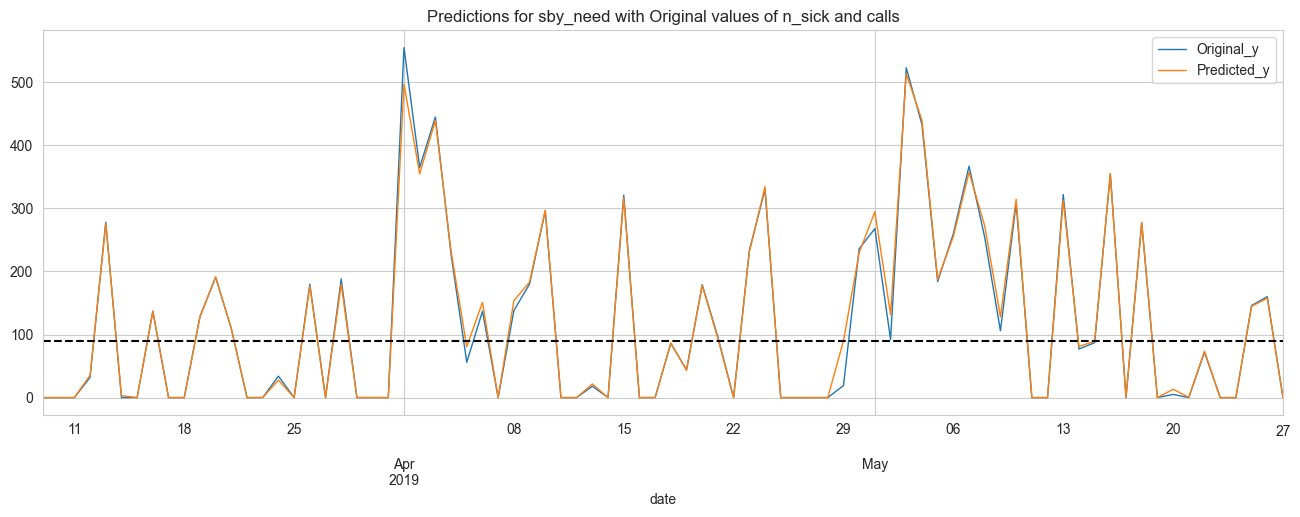

In [661]:
import seaborn as sns
color_pal = sns.color_palette()

results_df.plot(figsize=(16, 5),
                    color=color_pal,
                    ms=1,
                    lw=1,
                    title='Predictions for sby_need with Original values of n_sick and calls')
plt.axhline(y=90, color='black', linestyle='--', label='y=90')
plt.savefig('Predictions for sby_need with Original values of n_sick and calls.png')
plt.show()

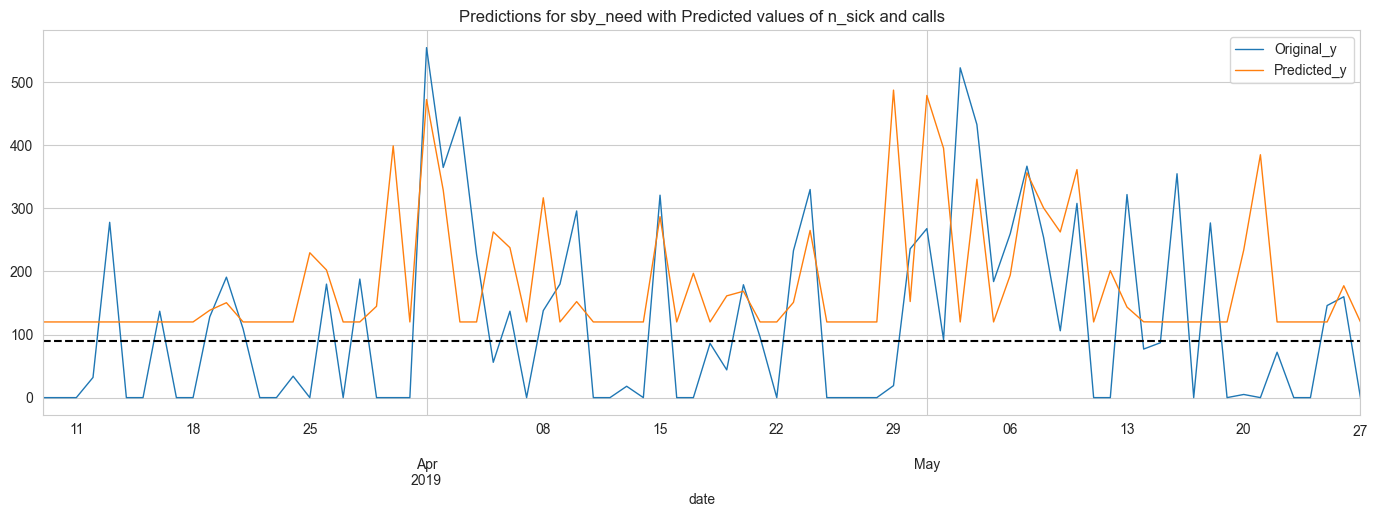

In [695]:
import seaborn as sns
color_pal = sns.color_palette()
results_df_new['Predicted_y'] = results_df_new['Predicted_y'].apply(lambda x: 120 if x < 120 else x)
results_df_new.plot(figsize=(17, 5),
                       color=color_pal,
                       ms=1,
                       lw=1,
                       title='Predictions for sby_need with Predicted values of n_sick and calls')
plt.axhline(y=90, color='black', linestyle='--', label='y=90')
plt.savefig('Predictions for sby_need with Predicted values of n_sick and calls.png')
plt.show()

In [663]:
current_month_data = data.loc['2019-05-01':'2019-05-27'][features].values
current_month_data = scaler.transform(current_month_data)
current_month_data

ValueError: X has 9 features, but StandardScaler is expecting 3 features as input.

In [ ]:

predicted_sby_need = model.predict(current_month_data)
predicted_sby_need

In [ ]:
# Get the sby_need values for the specified dates
actual_values = data.loc['2019-05-01':'2019-05-27', 'sby_need']

# Get the predicted forecasted values for the same dates
predicted_values = predicted_sby_need.flatten()

# Create a DataFrame for the actual and predicted values with dates as index
combined_df = pd.DataFrame({
    'Actual_sby_need': actual_values,
    'Forecasted_sby_need': predicted_values
}, index=actual_values.index)

# Print the combined DataFrame
print(combined_df)


In [ ]:
combined_df.plot(figsize=(16, 5),
               color=color_pal,
               ms=1,
               lw=1,
               title='Predictions')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4), facecolor='white')
sns.barplot(x='Importance', y='Feature', data=importance_df, color=color_pal[0], width=0.1)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig('Feature Importance.png')
plt.show()


In [ ]:
def add_lags(dtf):
    """
    Add lags in the time series
    :param dtf: dataframe
    :return:dataframe
    """
    target_map = dtf['sby_need'].to_dict()
    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf
def create_features(dtf) :
    """
    Create time series features from the time index.
    :param dtf: dataframe
    :return:dataframe
    """
    dtf = dtf.copy()
    dtf['dayofweek'] = dtf.index.dayofweek
    dtf['month'] = dtf.index.month
    dtf['year'] = dtf.index.year
    dtf['dayofyear'] = dtf.index.dayofyear
    dtf['dayofmonth'] = dtf.index.day
    dtf['weekofyear'] = dtf.index.isocalendar().week
    dtf['quarter'] = dtf.index.quarter
    return dtf




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load the dataset
data = pd.read_csv('sickness_table.csv', parse_dates=['date'], index_col='date')
dataframe = create_features(data)
data = add_lags(dataframe)

# Feature selection
features = ['n_sick', 'calls', 'n_duty', 'dayofweek', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'quarter', 'lag1', 'lag2', 'lag3']
data.fillna(0, inplace=True)
target = 'sby_need'
data = data[features + [target]]

# Prepare the data
X = data[features].values
y = data[target].values

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load the dataset
data = pd.read_csv('sickness_table.csv', parse_dates=['date'], index_col='date')
dataframe = create_features(data)
data = add_lags(dataframe)

# Feature selection
features = ['n_sick', 'calls', 'n_duty', 'dayofweek', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'quarter', 'lag1', 'lag2', 'lag3']
data.fillna(0, inplace=True)
target = 'sby_need'
data = data[features + [target]]

# Prepare the data
X = data[features].values
y = data[target].values

# Split data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Initialize XGBoost model for predicting 'n_sick'
xgb_n_sick = xgb.XGBRegressor(objective='reg:squarederror')
xgb_n_sick.fit(X_train, y_train)  # Train on the 'n_sick' column

# Make predictions on validation set for 'n_sick'
n_sick_val_pred = xgb_n_sick.predict(X_val)

# Initialize XGBoost model for predicting 'calls'
xgb_calls = xgb.XGBRegressor(objective='reg:squarederror')
xgb_calls.fit(X_train, y_train)  # Train on the 'calls' column

# Make predictions on validation set for 'calls'
calls_val_pred = xgb_calls.predict(X_val)

# Calculate RMSE for validation set of 'n_sick' prediction
rmse_n_sick_val = np.sqrt(mean_squared_error(y_val, n_sick_val_pred))
print(f"Validation RMSE for 'n_sick': {rmse_n_sick_val}")

# Calculate RMSE for validation set of 'calls' prediction
rmse_calls_val = np.sqrt(mean_squared_error(y_val, calls_val_pred))
print(f"Validation RMSE for 'calls': {rmse_calls_val}")

# Combine predictions of 'n_sick' and 'calls' to compute 'sby_need'
sby_need_val_pred = n_sick_val_pred / calls_val_pred

# Calculate RMSE for validation set of 'sby_need' prediction
rmse_sby_need_val = np.sqrt(mean_squared_error(y_val, sby_need_val_pred))
print(f"Validation RMSE for 'sby_need': {rmse_sby_need_val}")


In [ ]:
def add_lags(dtf, lag_df):
    """
    Add lags in the time series
    :param dtf: dataframe
    :param lag_df: dataframe with 'sby_need' values for lags
    :return: dataframe
    """
    lag_df = lag_df[['lag1', 'lag2', 'lag3']]  # Select only lag features from lag_df
    dtf = pd.concat([dtf, lag_df], axis=1)
    return dtf
# Specify the date range
start_date = '2019-05-01'
end_date = '2019-05-27'
# Create a DataFrame with the specified date range for forecast
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')
forecast_df = pd.DataFrame(index=forecast_dates)

# Prepare features for prediction
forecast_df['dayofweek'] = forecast_df.index.dayofweek
forecast_df['month'] = forecast_df.index.month
forecast_df['year'] = forecast_df.index.year
forecast_df['dayofyear'] = forecast_df.index.dayofyear
forecast_df['dayofmonth'] = forecast_df.index.day
forecast_df['weekofyear'] = forecast_df.index.isocalendar().week
forecast_df['quarter'] = forecast_df.index.quarter

# Predict 'n_sick' and 'calls' for the forecast period
n_sick_pred = xgb_n_sick.predict(forecast_df[features[:-1]])
calls_pred = xgb_calls.predict(forecast_df[features[:-1]])

# Calculate predicted 'sby_need'
sby_need_pred = n_sick_pred / calls_pred

# Add the predicted 'sby_need' values to the DataFrame
forecast_df['sby_need_predicted'] = sby_need_pred

# Plot the graph comparing original and predicted sby_need
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df['sby_need_original'], label='Original sby_need')
plt.plot(forecast_df.index, forecast_df['sby_need_predicted'], label='Predicted sby_need')
plt.xlabel('Date')
plt.ylabel('sby_need')
plt.title('Original vs Predicted sby_need')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the forecast DataFrame
print(forecast_df)
